# Data exploration

Upon downloading and (manually) splitting data according to metadata, I explore the dataset in order to understand it. Below I plot the sample images.

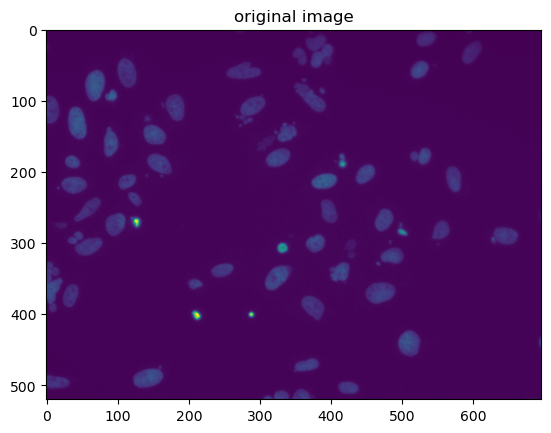

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

img_path = '/Users/julia/Desktop/CV_project2/images/training/IXMtest_L01_s3_w1E7E0D198-5FB4-4E10-A27C-C46463DA9E06.tif'
img = Image.open(img_path)
img_array = np.array(img)

plt.imshow(img_array)
plt.title('original image')
plt.show()

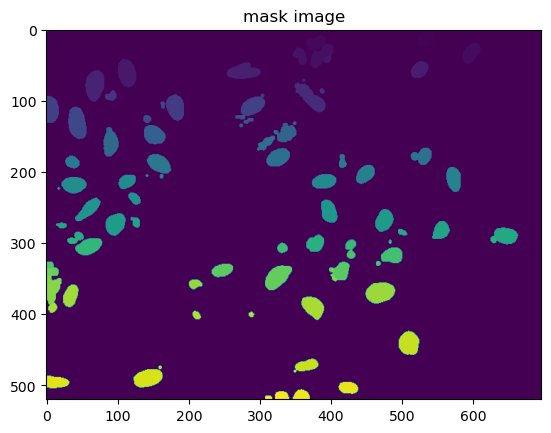

In [2]:
import skimage.io

mask_path = '/Users/julia/Desktop/CV_project2/masks/training/IXMtest_L01_s3_w1E7E0D198-5FB4-4E10-A27C-C46463DA9E06.png'
mask = skimage.io.imread(mask_path)
mask = mask[:,:,0]
mask = skimage.morphology.label(mask)
mask_array = np.array(mask)

plt.imshow(mask_array)
plt.title('mask image')
plt.show()

# Image segmentation

For image segmentation I have used a U-Net model. I think it is a good decision, since it was originally designed to deal with biomedical data. It consists of two parts - encoder and decoder. Encoder captures the context and reduces the spatial dimensions of the input image, while the decoder recovers the spatial information and generates a segmentation map.

### Model definition

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D

def unet(input_shape, num_classes):
    # Encoder
    inputs = Input(input_shape)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bridge
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    
    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    
    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    
    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    
    conv10 = Conv2D(num_classes, 1, activation='softmax')(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    
    return model

### Preparing data for an input

In [48]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Preprocessing - resizing, normalizing etc
image_dir = '/Users/julia/Desktop/CV_project2/images/training'
mask_dir = '/Users/julia/Desktop/CV_project2/masks/training'

image_files = os.listdir(image_dir)
mask_files = os.listdir(mask_dir)

images = []
masks = []

for image_file, mask_file in zip(image_files, mask_files):
    if mask_file != '.DS_Store':
        image_path = os.path.join(image_dir, image_file)
        mask_path = os.path.join(mask_dir, mask_file)
    
        image = Image.open(image_path).convert('L') 
        mask = Image.open(mask_path).convert('L')
        
        
        image = image.resize((256, 256))
        mask = mask.resize((256, 256))
    
        image_array = np.array(image)
        mask_array = np.array(mask)
    
        images.append(image_array)
        masks.append(mask_array)

images = np.array(images)
masks = np.array(masks)


preprocessed_images = images / 255.0 
preprocessed_masks = masks / 255.0 

# Encoding target values to categorical
preprocessed_masks = to_categorical(preprocessed_masks, num_classes = 2)

### Training the model

In [40]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import MeanIoU

# Hyperparameters
loss = BinaryCrossentropy()
metrics = [MeanIoU(num_classes=2)]
batch_size = 16
epochs = 4

input_shape = (256, 256, 1)
num_classes = 2


model = unet(input_shape, num_classes)
model.compile(optimizer='adam', loss=loss, metrics=metrics)
model.fit(preprocessed_images, preprocessed_masks, batch_size=batch_size, epochs=epochs)

Epoch 1/4
6/6 [==============================] - 111s 19s/step - loss: 0.2031 - mean_io_u_1: 0.7083
Epoch 2/4
6/6 [==============================] - 114s 19s/step - loss: 0.0000e+00 - mean_io_u_1: 1.0000
Epoch 3/4
6/6 [==============================] - 106s 18s/step - loss: 0.0000e+00 - mean_io_u_1: 1.0000
Epoch 4/4
6/6 [==============================] - 103s 17s/step - loss: 0.0000e+00 - mean_io_u_1: 1.0000


### Prediction example

1/1 [==============================] - 0s 368ms/step


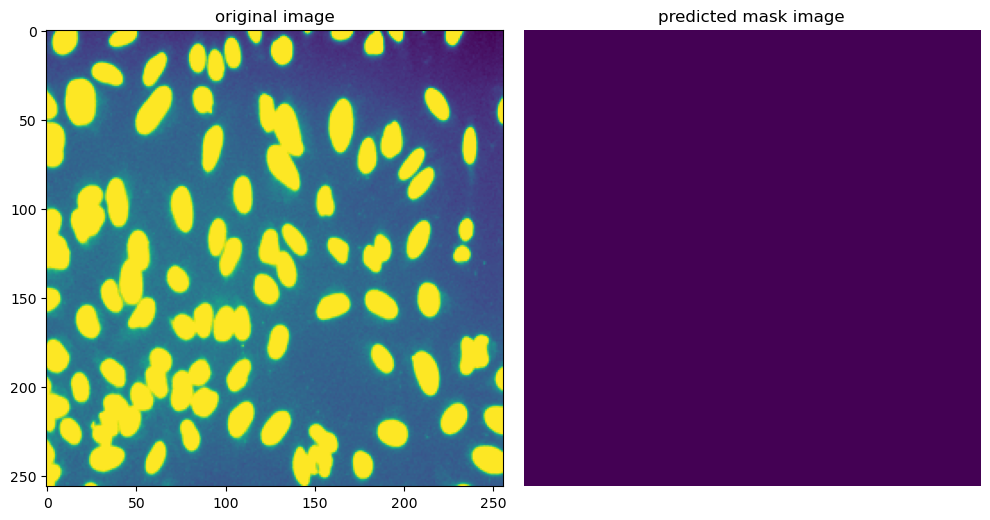

In [52]:
# Loading and preprocessing
img_path = '/Users/julia/Desktop/CV_project2/images/validation/IXMtest_B17_s7_w1215A0A98-4A76-4846-B54A-F7C1EAF84E02.tif'
sample_image = Image.open(img_path).convert('L')
sample_image = sample_image.resize((256, 256))
sample_image_array = np.array(sample_image) / 255.0
sample_image_array = np.reshape(sample_image_array, (1, 256, 256, 1))

# Predicting
predictions = model.predict(sample_image_array)
binary_mask = np.argmax(predictions, axis=-1)


# Visualizing
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(sample_image)
axes[0].set_title('original image')


axes[1].imshow(binary_mask[0] * 255)
axes[1].set_title('predicted mask image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

Unfortunately, the model assigned all pixels as the background - no cells segmented.

### Evaluation

In [58]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Preprocessing - resizing, normalizing etc
image_dir = '/Users/julia/Desktop/CV_project2/images/validation'
mask_dir = '/Users/julia/Desktop/CV_project2/masks/validation'

image_files = os.listdir(image_dir)
mask_files = os.listdir(mask_dir)

images = []
masks = []

for image_file, mask_file in zip(image_files, mask_files):
    if mask_file != '.DS_Store':
        image_path = os.path.join(image_dir, image_file)
        mask_path = os.path.join(mask_dir, mask_file)
    
        image = Image.open(image_path).convert('L') 
        mask = Image.open(mask_path).convert('L')
        
        
        image = image.resize((256, 256))
        mask = mask.resize((256, 256))
    
        image_array = np.array(image)
        mask_array = np.array(mask)
    
        images.append(image_array)
        masks.append(mask_array)

images = np.array(images)
masks = np.array(masks)


preprocessed_images = images / 255.0 
preprocessed_masks = masks / 255.0 

# Encoding target values to categorical
preprocessed_masks = to_categorical(preprocessed_masks, num_classes = 2)

In [59]:
# Evaluating the model on the validation data
loss, mean_iou = model.evaluate(preprocessed_images, preprocessed_masks)

# Print the evaluation results
print("Validation Loss:", loss)
print("Mean IoU:", mean_iou)

2/2 [==============================] - 16s 6s/step - loss: 0.0000e+00 - mean_io_u_1: 1.0000
Validation Loss: 0.0
Mean IoU: 1.0


Here on the other hand, the validation loss equals zero, which would mean the masks are perfectly predicted. Which in general would mean overfitting and is a bad sign. In this case however, in my opinion, it indicates that something is wrong with the evaluation process, as the example above shown that the mask was not predicted correctly.

# Image detection

For image detection I chose to use YOLO model. I have used an existing pretrained implementation from Ultralytics https://github.com/ultralytics/yolov5

### Preparing the data

### Bounding boxes

In order to fine-tune the YOLO model to work with the BBBC dataset, I have used a script below to create the bounding boxes for train, and validation masks. 

The final .txt files describing labels have a simple structure: class - bottom left corner - top left corner - bottom right corner - top right corner.

The coordinates are normalized. There will be <b>only one class "cell"</b> with label 0.

In [11]:
import cv2

def bounding_boxes(img_path):
    # Loading the mask
    mask = skimage.io.imread(img_path)
    mask = mask[:, :, 0]
    mask = skimage.morphology.label(mask)
    mask_array = np.array(mask)

    # Extracting and normalizing bounding boxes
    contours, _ = cv2.findContours(mask_array.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bounding_boxes = []
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        img_width, img_height = mask.shape[1], mask.shape[0]
        x_normalized = x / img_width
        y_normalized = y / img_height
        w_normalized = w / img_width
        h_normalized = h / img_height

        bounding_boxes.append((x_normalized, y_normalized, x_normalized + w_normalized, y_normalized + h_normalized))
    
    return bounding_boxes


In [12]:
folder_path = '/Users/julia/Desktop/yoloval/'

for filename in os.listdir(folder_path):
    # Creating bounding boxes for each image from the folder
    image_path = os.path.join(folder_path, filename)
    bounding_bxs = bounding_boxes(image_path)
    
    # Adjusting the data to correct format
    bounding_bxs = str(bounding_bxs)
    bounding_bxs = bounding_bxs.replace("[", "")
    bounding_bxs = bounding_bxs.replace("]", "")
    bounding_bxs = bounding_bxs.replace("(", "0 ")
    bounding_bxs = bounding_bxs.replace("), ", "\n")
    bounding_bxs = bounding_bxs.replace(",", "")
    bounding_bxs = bounding_bxs.replace(")", "")
    
    # Saving the image
    f_name = filename.replace(".tif", ".txt")
    with open(f_name, 'w') as f:
        f.write(str(bounding_bxs))

### Preparing correct folder structure and .yaml file

After cloning yolov5 repository, I added a directories containing images, their bounding boxes and .yaml file.
The final structure is as follows:

YOLOV5:

&emsp;CELLS:
   
       [] data.yaml
       [] train
           [] images (containing .tif images)
           [] labels (containing .txt files with bounding boxes)
       [] val
           [] images (containing .tif images)
           [] labels (containing .txt files with bounding boxes)

data.yaml file indicates location of train and val sets and the classes. It looks as follows.

In [ ]:
train: /Users/julia/Desktop/yolov5/cells
val: /Users/julia/Desktop/yolov5/cells

nc: 1
names: ['cell']

### Training YOLO model on BBBC data

In order to train the model I have run train.py file with defined parameters, as shown below:

<b> python train.py --weight yolov5s.pt --data cells/data.yaml --batch-size 8 --epochs 1 </b>

In [ ]:
(venv) (base) julia@MBP-Julia yolov5 % python train.py --weight yolov5s.pt --data cells/data.yaml --batch-size 8 --epochs 1

train: weights=yolov5s.pt, cfg=, data=cells/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=1, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-178-ga199480 Python-3.9.15 torch-2.0.1 CPU


hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, scale=0.5, shear=0.0, perspective=0.0, flipud=0.0, fliplr=0.5, mosaic=1.0, mixup=0.0, copy_paste=0.0
ClearML: run 'pip install clearml' to automatically track, visualize and remotely train YOLOv5 🚀 in ClearML
Comet: run 'pip install comet_ml' to automatically track and visualize YOLOv5 🚀 runs in Comet
TensorBoard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
Overriding model.yaml nc=80 with nc=1


                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Focus                     [3, 32, 3]                    
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  3    156928  models.common.C3                        [128, 128, 3]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  3    625152  models.common.C3                        [256, 256, 3]                 
  7                -1  1   1180672  models.common.Conv                      [256, 512, 3, 2]              
  8                -1  1    656896  models.common.SPP                       [512, 512, [5, 9, 13]]        
  9                -1  1   1182720  models.common.C3                        [512, 512, 1, False]          
 10                -1  1    131584  models.common.Conv                      [512, 256, 1, 1]              
 11                -1  1         0  torch.nn.modules.upsampling.Upsample    [None, 2, 'nearest']          
 12           [-1, 6]  1         0  models.common.Concat                    [1]                           
 13                -1  1    361984  models.common.C3                        [512, 256, 1, False]          
 14                -1  1     33024  models.common.Conv                      [256, 128, 1, 1]              
 15                -1  1         0  torch.nn.modules.upsampling.Upsample    [None, 2, 'nearest']          
 16           [-1, 4]  1         0  models.common.Concat                    [1]                           
 17                -1  1     90880  models.common.C3                        [256, 128, 1, False]          
 18                -1  1    147712  models.common.Conv                      [128, 128, 3, 2]              
 19          [-1, 14]  1         0  models.common.Concat                    [1]                           
 20                -1  1    296448  models.common.C3                        [256, 256, 1, False]          
 21                -1  1    590336  models.common.Conv                      [256, 256, 3, 2]              
 22          [-1, 10]  1         0  models.common.Concat                    [1]                           
 23                -1  1   1182720  models.common.C3                        [512, 512, 1, False]          
 24      [17, 20, 23]  1     16182  models.yolo.Detect                      [1, [[10, 13, 16, 30, 33, 23], [30, 61, 62, 45, 59, 119], [116, 90, 156, 198, 373, 326]], [128, 256, 512]]
Model summary: 225 layers, 7063542 parameters, 7063542 gradients

Transferred 355/361 items from yolov5s.pt
optimizer: SGD(lr=0.01) with parameter groups 59 weight(decay=0.0), 62 weight(decay=0.0005), 62 bias
train: Scanning /Users/julia/Desktop/yolov5/cells/test/labels... 191 images
train: New cache created: /Users/julia/Desktop/yolov5/cells/test/labels.cache
val: Scanning /Users/julia/Desktop/yolov5/cells/val/labels... 46 images, 5 backg
val: New cache created: /Users/julia/Desktop/yolov5/cells/val/labels.cache

AutoAnchor: 2.52 anchors/target, 0.939 Best Possible Recall (BPR). Anchors are a poor fit to dataset ⚠️, attempting to improve...
AutoAnchor: WARNING ⚠️ Extremely small objects found: 13 of 13942 labels are <3 pixels in size
AutoAnchor: Running kmeans for 9 anchors on 13942 points...
AutoAnchor: Evolving anchors with Genetic Algorithm: fitness = 0.7306: 100%|████
AutoAnchor: thr=0.25: 0.9760 best possible recall, 5.07 anchors past thr
AutoAnchor: n=9, img_size=640, metric_all=0.340/0.735-mean/best, past_thr=0.496-mean: 40,291, 121,99, 390,32, 129,340, 458,100, 269,194, 295,384, 513,221, 530,392
AutoAnchor: Done ✅ (optional: update model *.yaml to use these anchors in the future)
Plotting labels to runs/train/exp7/labels.jpg... 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/train/exp7
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
        0/0         0G     0.1077     0.7192          0       1717        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         50       4459      0.153      0.515      0.173     0.0552

1 epochs completed in 0.017 hours.
Optimizer stripped from runs/train/exp7/weights/last.pt, 14.5MB
Optimizer stripped from runs/train/exp7/weights/best.pt, 14.5MB

Validating runs/train/exp7/weights/best.pt...
Fusing layers... 
Model summary: 166 layers, 7053910 parameters, 0 gradients
                 Class     Images  Instances          P          R      mAP50   
                   all         50       4459      0.152      0.513      0.173     0.0555
Results saved to runs/train/exp7

### Prediction example

After the training, the model saved best weights, which I have used for prediciton

In [ ]:
(venv) (base) julia@MBP-Julia yolov5 % python detect.py --weights runs/train/exp7/weights/best.pt --source /Users/julia/Desktop/yolov5/cells/test/images/IXMtest_A09_s1_w1CE70AD49-290D-4312-82E6-CDC717F32637.tif
detect: weights=['runs/train/exp7/weights/best.pt'], source=/Users/julia/Desktop/yolov5/cells/test/images/IXMtest_A09_s1_w1CE70AD49-290D-4312-82E6-CDC717F32637.tif, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-178-ga199480 Python-3.9.15 torch-2.0.1 CPU

Fusing layers... 
Model summary: 166 layers, 7053910 parameters, 0 gradients
image 1/1 /Users/julia/Desktop/yolov5/cells/test/images/IXMtest_A09_s1_w1CE70AD49-290D-4312-82E6-CDC717F32637.tif: 480x640 (no detections), 80.9ms
Speed: 0.4ms pre-process, 80.9ms inference, 0.1ms NMS per image at shape (1, 3, 640, 640)

Results saved to runs/detect/exp4

Below the image detection example.

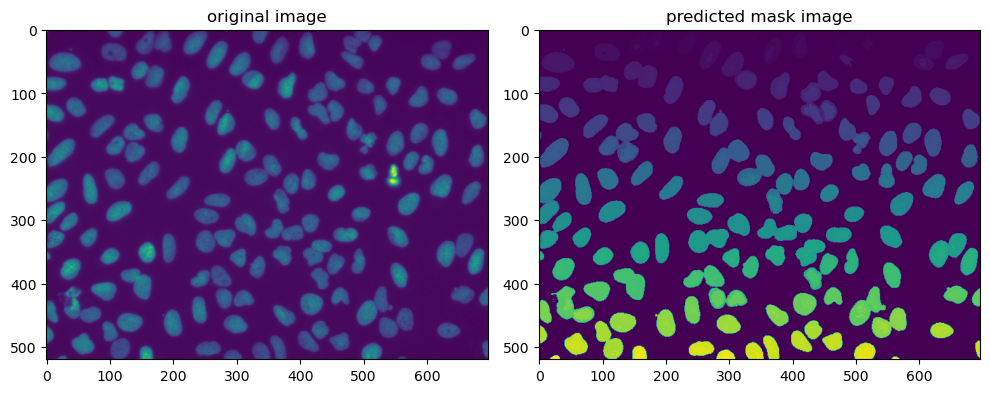

In [5]:
# Loading and preprocessing
img_path = '/Users/julia/Desktop/yolov5/cells/test/images/IXMtest_A09_s1_w1CE70AD49-290D-4312-82E6-CDC717F32637.tif'
mask_path = '/Users/julia/Desktop/CV_project2/predicted.tif'

img = Image.open(img_path)
img_array = np.array(img)

mask = skimage.io.imread(mask_path)
mask = mask[:,:,0]
mask = skimage.morphology.label(mask)
mask_array = np.array(mask)

# Visualizing
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img_array)
axes[0].set_title('original image')

axes[1].imshow(mask_array)
axes[1].set_title('predicted mask image')

plt.tight_layout()
plt.show()

Shown with bounding boxes:

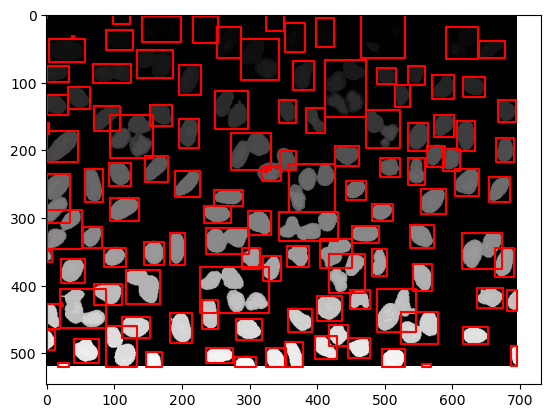

In [6]:
# Load the mask image and keep the first channel only
mask = skimage.io.imread('/Users/julia/Desktop/CV_project2/predicted.tif')
mask = mask[:, :, 0]
mask = skimage.morphology.label(mask)
mask_array = np.array(mask)

contours, _ = cv2.findContours(mask_array.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

bounding_boxes = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    bounding_boxes.append((x, y, x + w, y + h))

# Visualize the bounding boxes on the image
plt.imshow(img_array, cmap='gray')
for box in bounding_boxes:
    x_min, y_min, x_max, y_max = box
    plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], 'r')
plt.show()


### Evaluation

In order to validate the model I predict the masks for all of the images from validation set (by running python detect.py --weights runs/train/exp7/weights/best.pt ...) and compare the predicted bounding boxes with real ones.

### Intersection over union score

In [4]:
def calculate_iou(box1, box2):
    # Extracting coordinates
    x1_box1, y1_box1, x2_box1, y2_box1 = box1
    x1_box2, y1_box2, x2_box2, y2_box2 = box2

    # Calculating area of intersection
    intersection_width = min(x2_box1, x2_box2) - max(x1_box1, x1_box2)
    intersection_height = min(y2_box1, y2_box2) - max(y1_box1, y1_box2)

    # If bounding boxes do not intersect
    if intersection_width <= 0 or intersection_height <= 0:
        return 0.0

    intersection_area = intersection_width * intersection_height

    # Calculating area of union
    area_box1 = (x2_box1 - x1_box1) * (y2_box1 - y1_box1)
    area_box2 = (x2_box2 - x1_box2) * (y2_box2 - y1_box2)
    union_area = area_box1 + area_box2 - intersection_area

    return intersection_area / union_area

In [16]:
image_path = '/Users/julia/Desktop/yolov5_val/labels/'
mask_path = '/Users/julia/Desktop/yolov5_val/predicted/'

ious_overall = []
bb_not_found = 0 
bb_overall = 0

# For each image
for filename in os.listdir(image_path):
    if filename != '.DS_Store':
        original_path = os.path.join(image_path, filename)
        predicted_path = os.path.join(mask_path, filename)
    
        with open(original_path, "r") as file1:
            bbox1_lines = file1.readlines()

        with open(predicted_path, "r") as file2:
            bbox2_lines = file2.readlines()
    
        ious = []
    
        # For each bounding box from predicted & from original mask
        for bbox1_line, bbox2_line in zip(bbox1_lines, bbox2_lines):
            bbox1 = tuple(map(float, bbox1_line.strip().split()))
            bbox2 = tuple(map(float, bbox2_line.strip().split()))

            # Calculating iou
            iou_score = calculate_iou(bbox1, bbox2)
        
            if iou_score != 0.0:
                ious.append(iou_score)
                bb_not_found +=1
            
            bb_overall += 1
        
    
        if ious:
            ious_overall.append(sum(ious)/len(ious))

### The mean intersection over unit for the whole validation set

Here I have considered only the bounding boxes which intersected. I have removed outliers, so the bounding boxes that did not have any intersection.

In [11]:
print(sum(ious_overall)/len(ious_overall))

0.7004980343711256


The mean of IoU score at 0.7 I consider as a "good" result, but not excellent.

### Number of bounding boxes that were found (at least some intersection)

In [24]:
print(str(bb_overall - bb_not_found) + " / " + str(bb_overall))
print(str(round(((bb_overall - bb_not_found)/bb_overall)*100,2)) + "%")

3601 / 4226
85.21%


I think there were quite many bounding boxes that did not intersect at all. Probably it is caused by wrong identification of coresponding boxes. The calculations are done one by one, so it can happen that the function compares two random boxes that do not detect the same cell.